<a href="https://colab.research.google.com/github/RYU-MCFLY/Aplicaciones-Financieras/blob/main/CCP7_2_Aps_Financieras5_Hierarchical_Risk_Parity26MAY23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana7/2_Hierarchical_Risk_Parity.ipynb)

# Introducción

Critical Line Algorithm (CLA) es un algoritmo para obtener portafolios con mínima varianza sin la necesidad de utilizar programación cuadrática.

Obtenido de 

> David H. Bailey and Marcos Lopez de Prado, "An open-source implementation of the critical line algorithm for portfolio optimization," Algorithms, vol. 6 (2013), pg. 169-196, DOI: 10.3390/a6010169

Se puede encontrar la [publicación](https://ssrn.com/abstract=2197616) y el [código](https://www.davidhbailey.com/dhbpapers/CLA-files.zip) en https://www.davidhbailey.com/dhbpapers/.

In [1]:
%%writefile CLA.py
#!/usr/bin/env python
# On 20121129
# Critical Line Algorithm
# by MLdP <lopezdeprado@lbl.gov>

import numpy as np
#---------------------------------------------------------------
#---------------------------------------------------------------
class CLA:
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in=None
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l_in is None or l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=None
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==None or l<self.l[-1]) and (l_out is None or l>l_out):
                        l_out,i_out=l,i                
            #3) decide lambda
            if (l_in==None or l_in<0) and (l_out==None or l_out<0):break
            if l_in is not None and (l_out is None or l_in > l_out):
                self.l.append(l_in)
                f.remove(i_in)
                w[i_in]=bi_in # set value at the correct boundary
            else:
                self.l.append(l_out)
                f.append(i_out)
            #4) compute solution vector
            covarF,covarFB,meanF,wB=self.getMatrices(f)
            covarF_inv=np.linalg.inv(covarF)
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if len(f)==self.mean.shape[0]:
                #5) minimum variance solution
                wF,g=self.computeW(covarF_inv,covarFB,np.zeros(meanF.shape),wB)
                for i in range(len(f)):w[f[i]]=wF[i]
                self.w.append(np.copy(w)) # store solution
                self.g.append(g)
                self.f.append(f[:])
#---------------------------------------------------------------    
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=list(zip(range(self.mean.shape[0]),b)) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1]
        if c<0:
            bi=bi[0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if np.all(wB)==None:
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if np.all(wB==None):
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        matrix = np.array(matrix)
        # Reduce a matrix to the provided list of rows and columns
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1)
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed 
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
#---------------------------------------------------------------
#---------------------------------------------------------------

Writing CLA.py


# Dependencia

In [2]:
!pip install -U scipy yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import random
import numpy as np
import pandas as pd

import yfinance as yf

from scipy.spatial.distance import squareform

from CLA import CLA

# Bases de HRP

El algoritmo consta de 3 grandes pasos:

- Hierarchical Tree Clustering

- Matrix Seriation

- Recursive Bisection

# Funciones

La siguiente función nos crea un portafolio en que los pesos asignados a cada activo se toman como valores inversos a sus varianzas (inversiones mas seguras)

In [4]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [5]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems,cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

La siguiente función sirve para reorganizar las filas y las columnas de la matriz de covarianzas para que los valores más grandes se queden alrededos de la diagonal. Esta tiene un propiedad útil: Inversiones similares son posicionadas juntas y distintos son puestos lejos unos de otros.

In [6]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0,sortIx.shape[0]*2,2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;j = df0.values-numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1],index = i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

La siguiente función regresa los pesos del portafolio de acuerdo al agoritmo de HRP:

Para crear los pesos, se usa la "inverse-variance allocation", el algoritmo es el siguiente:

1. El algoritmo se inicializa:
  
  a. Creando una lista de objetos: $L = \left\{ L_0 \right\}$ con $L_0 = \left\{ n\right\}_{n=1, \dots, N}$

  b. Asignando un peso unitario a todos los objetos: $w_n = 1$, $\forall n = 1, \dots, N$

2. Si $\|L_i\| = 1$, $\forall L_i \in L$ detenerse.
3. Para cada $L_i \in L$ tal que $\|L_i\| > 1$:

  a. bisectar $L_i$ en dos subconjuntos, $L_i^{(1)} \cup L_i^{(2)} = L_i$, donde $\|L_i^{(1)}\| = int\left[ \frac{1}{2}\|L_i\| \right]$, y el orden es preservado

  b. define la varianza de $L_i^{(j)}$, $j = 1, 2$ como la forma cuadrática $\tilde{V}_i^{(j)} \equiv \tilde{w}_i^{(j)^{T}} V_i^{(j)} \tilde{w}_i^{(j)}$, donde $V_i^{(j)}$ es la matriz de covarianza entre los que conforman la bisección $L_i^{(j)}$, y $\tilde{w}_i^{(j)} = diag\left[ V_i^{(j)}\right] ^ {-1} \frac{1}{tr\left[ diag\left[ V_i^{(j)}\right] \right]}$, donde $diag\left[ . \right]$ y $tr \left[ . \right]$ son los operadores diagonal y traza.
  
  c. Calcula el factor de división: $\alpha_i = 1 - \frac{\tilde{V}_i^{(1)}}{\tilde{V}_i^{(1)}+\tilde{V}_i^{(2)}}$, tal que $0 \leq \alpha_i \leq 1$

  d. re-escala los pesos por un factor de $\alpha_i$, $\forall n \in L_i^{(1)}$

  re-escala los pesos por un factor de $\left(1 - \alpha_i \right)$, $\forall n \in L_i^{(2)}$

4. Repite desde el paso 2.

In [7]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1,index = sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [
                  i[j:k] 
                  for i in cItems 
                  for j, k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) 
                  if len(i) > 1
        ] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i+1] # cluster 2
            cVar0 = getClusterVar(cov,cItems0)
            cVar1 = getClusterVar(cov,cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [8]:
def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean = np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

In [9]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0< = d[i,j]< = 1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5 # distance matrix
    return squareform(dist)

In [10]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels = []
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.savefig(path)
    plt.clf();plt.close() # reset pylab
    return

In [11]:
def get_allocations(x, return_linkage = False):
    #1) Load the data
    cov, corr = x.cov(), x.corr()
    #2) compute and plot correl matrix
    plotCorrMatrix('HRP3_corr0.png',corr,labels = corr.columns)
    #3) cluster
    dist = correlDist(corr)
    link = sch.linkage(dist,'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels
    df0 = corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels = df0.columns)
    #4) Capital allocation
    hrp = getRecBipart(cov,sortIx)
    allocation = hrp.to_frame(name = 'HRP').sort_index()
    allocation['CLA'] = np.round(getCLA(cov), 6)
    if return_linkage:
        return allocation, link
    return allocation

# Datos

Utilizaremos las acciones de diversas compañias especializadas en tecologías relacionada a informática: Apple, IBM, Microsoft, Palantir Tech, Fastly, CloudFlare, Datadog, Zscaler, Snowflake.

In [12]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        # tickers = "GOOG AAPL IBM MSFT FB NFLX AMZN PLTR FSLY NET DDOG ZS SNOW",
        tickers = "AAPL IBM MSFT PLTR FSLY NET DDOG ZS SNOW NFLX AMZN",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close'].dropna()
data

[*********************100%***********************]  11 of 11 completed


,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2022-05-27,148.751770,115.146500,98.070000,13.18,132.461197,270.624084,58.910000,195.190002,8.85,129.910004,160.000000
2022-05-31,147.956512,120.209503,95.389999,13.05,132.052216,269.267242,56.000000,197.440002,8.68,127.650002,153.089996
2022-06-01,147.827286,121.683998,97.500000,12.62,132.613373,269.811951,55.110001,192.910004,8.46,126.150002,148.940002
2022-06-02,150.312454,125.511002,110.080002,13.01,133.298187,271.951233,57.900002,205.089996,9.30,138.240005,160.839996
2022-06-03,144.517059,122.349998,105.440002,12.43,134.277817,267.434906,54.540001,198.979996,8.94,129.820007,156.929993
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,174.199997,115.010002,93.870003,13.46,127.500000,321.179993,56.799999,363.010010,11.84,178.470001,128.860001
2023-05-23,171.559998,114.989998,93.070000,14.48,128.179993,315.260010,55.919998,355.989990,12.64,175.160004,124.470001
2023-05-24,171.839996,116.750000,93.440002,14.82,125.680000,313.850006,56.230000,364.850006,12.23,177.139999,126.529999


# Rendimientos

In [13]:
x = np.log(data.iloc[:-20,:] / data.iloc[:-20,:].shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2022-05-31,-1.350858,10.843775,-6.982356,-2.497926,-0.779268,-1.266643,-12.766109,2.888247,-4.887776,-4.422543,-11.125260
2022-06-01,-0.220195,3.072239,5.513416,-8.443336,1.068608,0.509263,-4.037164,-5.849166,-6.469441,-2.978758,-6.925566
2022-06-02,4.201231,7.803410,30.581463,7.669736,1.297978,1.990176,12.445325,15.428728,23.855641,23.062954,19.370359
2022-06-03,-9.908287,-6.427925,-10.852455,-11.492556,1.845216,-4.220134,-15.065320,-7.621638,-9.948677,-15.836288,-6.201785
2022-06-06,1.313951,4.976132,-5.508941,0.000000,3.016317,-1.188014,-2.927839,-2.341121,1.125001,-3.420115,2.619889
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.472951,-1.773240,-5.950196,-7.313886,-0.662288,-3.543437,-1.206703,0.797792,-2.476676,-4.695040,-2.615024
2023-04-25,-2.389080,-8.787938,-11.856394,-16.305816,0.982765,-5.744045,-18.439602,-5.004816,-11.456538,-12.748211,-21.794910
2023-04-26,-0.015401,5.852548,25.152105,-2.029539,-0.080077,17.622746,6.128354,-1.096160,0.000000,20.668197,2.038956


In [14]:
x_prueba = data.iloc[-20:, :].copy()
x_prueba

,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2023-05-01,169.355743,102.050003,65.400002,14.73,124.393814,304.893494,44.720001,324.119995,7.78,146.970001,88.739998
2023-05-02,168.307190,103.629997,64.040001,14.19,123.476326,304.743805,42.880001,317.549988,7.59,144.839996,87.000000
2023-05-03,167.218704,103.650002,65.839996,13.53,121.789330,303.736023,41.900002,319.299988,7.56,144.639999,87.370003
2023-05-04,165.560989,104.000000,75.400002,11.85,120.921165,304.743805,40.480000,320.779999,7.38,155.270004,87.739998
2023-05-05,173.330261,105.660004,76.570000,11.78,121.986641,309.972382,44.070000,322.760010,7.41,154.169998,89.459999
2023-05-08,173.260345,105.830002,78.540001,12.47,121.740005,307.976746,46.310001,331.209991,7.74,160.419998,107.919998
2023-05-09,171.532745,106.620003,79.589996,12.31,121.169998,306.330353,47.150002,332.140015,9.55,163.869995,110.044998
2023-05-10,173.320267,110.190002,86.000000,13.03,122.019997,311.628754,49.209999,335.420013,9.94,172.039993,116.790001
2023-05-11,173.510010,112.180000,86.650002,13.14,120.900002,309.433533,50.020000,344.760010,9.88,170.070007,115.419998


In [15]:
ganancia_mes_final =  x_prueba.iloc[-1,:] / x_prueba.iloc[1,:]
ganancia_mes_final

AAPL    1.042320
AMZN    1.159027
DDOG    1.454716
FSLY    1.087386
IBM     1.043844
MSFT    1.092360
NET     1.425840
NFLX    1.193135
PLTR    1.798419
SNOW    1.035695
ZS      1.501379
dtype: float64

# Portafolios

<ipython-input-6-f89148bc0f69>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sortIx = sortIx.append(df0) # item 2
<ipython-input-6-f89148bc0f69>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sortIx = sortIx.append(df0) # item 2
<ipython-input-6-f89148bc0f69>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sortIx = sortIx.append(df0) # item 2
<ipython-input-6-f89148bc0f69>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sortIx = sortIx.append(df0) # item 2
<ipython-input-6-f89148bc0f69>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

{'icoord': [[45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [65.0, 65.0, 83.75, 83.75],
  [42.5, 42.5, 74.375, 74.375],
  [25.0, 25.0, 58.4375, 58.4375],
  [15.0, 15.0, 41.71875, 41.71875],
  [5.0, 5.0, 28.359375, 28.359375]],
 'dcoord': [[0.0, 0.3487887065456236, 0.3487887065456236, 0.0],
  [0.0, 0.35751807863965374, 0.35751807863965374, 0.3487887065456236],
  [0.0, 0.2982830862052874, 0.2982830862052874, 0.0],
  [0.0, 0.31106758389777106, 0.31106758389777106, 0.2982830862052874],
  [0.0, 0.33144026063513743, 0.33144026063513743, 0.31106758389777106],
  [0.0, 0.3879898168192394, 0.3879898168192394, 0.33144026063513743],
  [0.35751807863965374,
   0.38843740104426333,
   0.38843740104426333,
   0.3879898168192394],
  [0.0, 0.42849944963243414, 0.42849944963243414, 0.38843740104426333],
  [0.0, 0.45665084462239436, 0.45665084462239436, 0.42849944963243414],
  [0.0, 0.49983975766683864, 0.4998

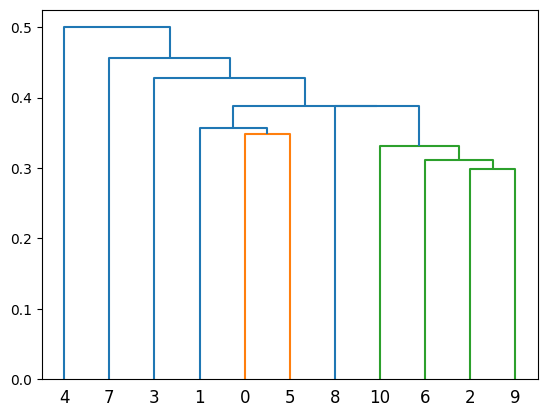

In [16]:
allocation, linkage = get_allocations(x, True)
sch.dendrogram(linkage)

In [17]:
data.columns

Index(['AAPL', 'AMZN', 'DDOG', 'FSLY', 'IBM', 'MSFT', 'NET', 'NFLX', 'PLTR',
       'SNOW', 'ZS'],
      dtype='object')

In [18]:
allocation

,HRP,CLA
AAPL,0.118830,-0.000000
AMZN,0.061288,0.000000
DDOG,0.017903,0.000000
FSLY,0.029302,0.000000
IBM,0.489414,0.852063
MSFT,0.124736,0.138478
NET,0.018299,0.000000
NFLX,0.083240,0.009459
PLTR,0.021196,0.000000
SNOW,0.015408,0.000000


In [19]:
capital_inicial = 1e6

In [20]:
ganancia_mes_final

AAPL    1.042320
AMZN    1.159027
DDOG    1.454716
FSLY    1.087386
IBM     1.043844
MSFT    1.092360
NET     1.425840
NFLX    1.193135
PLTR    1.798419
SNOW    1.035695
ZS      1.501379
dtype: float64

In [21]:
# ¿Que es este valor? - Como reparto mi capital
allocation.HRP*capital_inicial

AAPL    118829.578385
AMZN     61288.112362
DDOG     17903.432893
FSLY     29301.906561
IBM     489414.120903
MSFT    124736.070049
NET      18299.128949
NFLX     83240.083625
PLTR     21196.306201
SNOW     15407.892083
ZS       20383.367989
Name: HRP, dtype: float64

In [22]:
# ¿Qué representa este número? Ganancia final despues de 1 mes
np.dot(allocation.HRP*capital_inicial, ganancia_mes_final)

1110017.729058858

In [23]:
# ¿Y este número? Ganancia final despues de un mes
np.dot(np.abs(allocation.CLA)*capital_inicial, ganancia_mes_final)

1051974.4186909432

# Ejercicio:

Lo que se hizo fue obtener datos de un año. Los primero 11 meses se utilizan para el algoritmo y el último mes se reserva para probar efectividad del algoritmo.

AHORA, ustedes deben obtener un periodo de 2 años de información y van a:

- Utilizar el primer año para obtener los portafolios con los algoritmos HRP y CLA

- Obtener como cambiaría la inversión mes con mes, es decir: 
  - De los datos del segundo año tendremos 12 meses de datos.
  - Veamos como cambia la inversión de tiempo 0 final del mes 1 (30 dias despues o 20 periodos de trading)
  - Despues como cambia del tiempo 0 al final del mes 2 (60 días o aprox. 40 periodos de trading)
  - Despues como cambia del tiempo 0 al final del mes 3 (90 dias o aprox. 60 días de trading)
  - Continuar con ese proceso. lo que nos daria 12 valores para cada portafolio (2 vectores)

- Graficar dicho cambio en el tiempo

# Graficar Comparación

In [ ]:
import plotly.express as px

In [ ]:
# Graficar como avanza en el tiempo el ejercicio de arriba

#fig = px.line('', markers = True)  # cumsum
#fig.update_layout(hovermode = 'x')
#fig.show()

In [ ]:
# Como se comportan los activos en todo el periodo
px.line(data)